In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
from unidecode import unidecode
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, LSTM, Embedding, concatenate, Bidirectional
from keras.models import Model

# Hyperparametros e constantes
vocab_size = 5000
embedding_dim = 64
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

# FUNções
def cleantexts(text): #limpa campo de tecxto fornecido
    # preprocessing steps
    text = str(text)
    # convert to lowercase
    text = text.lower()
    # delete digits, special chars, etc., 
    text = unidecode(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    # delete additional spaces
    text = text.replace('\s+', ' ')
    # add start and end tags to the caption
    #text = '< ' + " ".join([word for word in text.split() if len(word)>1]) + ' >'
    return text

def norm_recom(rec): #Mapeia recomendações YesNo para 1 e 0
    if rec == 'Yes':
        return 1
    else:
        return 0

In [3]:
dfraw = pd.read_csv('train.csv', low_memory=False, parse_dates=[1])
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79425 entries, 0 to 79424
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     79425 non-null  int64         
 1   submission_date        79425 non-null  datetime64[ns]
 2   reviewer_id            79425 non-null  object        
 3   reviewer_birth_year    75874 non-null  float64       
 4   reviewer_gender        76941 non-null  object        
 5   reviewer_state         77023 non-null  object        
 6   product_id             79425 non-null  object        
 7   product_name           79373 non-null  object        
 8   product_brand          24646 non-null  object        
 9   site_category_lv1      79421 non-null  object        
 10  site_category_lv2      77007 non-null  object        
 11  review_title           79248 non-null  object        
 12  review_text            77458 non-null  object        
 13  r

In [4]:
#Limpar DF e passar preprocessamento no texto
df = dfraw[['review_title', 'review_text','recommend_to_a_friend', 'rating']].dropna()
df['clean_text'] = df.review_title.apply(lambda x: cleantexts(x)) + ' ' + df.review_text.apply(lambda x: cleantexts(x))

# tokenizae texto
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(list(df.clean_text.values))

word_index = tokenizer.word_index

# maior revisao
max_length = max(len(text.split()) for text in df.clean_text)
max_length

# Criar litas de Xs e y

reviews = list(df.clean_text.values)
recomends = df.recommend_to_a_friend.apply(lambda x: norm_recom(str(x))).values
ratings = list(df.rating.apply(lambda x: str(x)))

# Separa treino e validação

train_size = int(len(reviews) * training_portion)

reviews_train = reviews[0: train_size]
ratings_train = ratings[0: train_size]

reviews_val = reviews[train_size:]
ratings_val = ratings[train_size:]

recomends_train = recomends[0: train_size]
recomends_val = recomends[train_size:]

# Tokenizar textos e aplicar padding (preparação final dos dados)

X1_train = tokenizer.texts_to_sequences(reviews_train)
X2_train = recomends_train

X1_val = tokenizer.texts_to_sequences(reviews_val)
X2_val = recomends_val

X1_train = pad_sequences(X1_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X1_val = pad_sequences(X1_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Tokeniza variaveis de saída (rating)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(ratings_train)
output_size = len(label_tokenizer.word_index)+1

y_train = np.array(label_tokenizer.texts_to_sequences(ratings_train))
y_val = np.array(label_tokenizer.texts_to_sequences(ratings_val))

In [6]:
def Criar_Modelo(): # CRAÇÃO DO MODELO

    # metadata (recomenda ou nao para amigo)
    input_meta = Input(shape=(1,), name='Input Meta Data')

    # sequencial (LSTM para textos)
    inputs_text = Input(shape=(max_length))
    embedding = Embedding(vocab_size, embedding_dim, name='Embedding')(inputs_text)
    recurrent = Bidirectional(tf.keras.layers.LSTM(embedding_dim), name='LSTM_bid')(embedding)

    # decoder model (Concatena inputs e decodifica)
    decoder1 = concatenate([input_meta, recurrent])
    decoder2 = Dense(embedding_dim, activation='relu')(decoder1)
    outputs = Dense(output_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs_text, input_meta], outputs=outputs)

    return model

In [7]:
model = Criar_Modelo()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 632)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 632, 64)              320000    ['input_1[0][0]']             
                                                                                                  
 Input Meta Data (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 LSTM_bid (Bidirectional)    (None, 128)                  66048     ['Embedding[0][0]']       

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
num_epochs = 10
history = model.fit((X1_train, X2_train ), y_train, epochs=num_epochs, validation_data=((X1_val, X2_val), y_val), verbose=1, batch_size=1000)

Epoch 1/10
62/62 [==============================] - 245s 4s/step - loss: 1.2662 - accuracy: 0.4601 - val_loss: 0.9325 - val_accuracy: 0.5976
Epoch 2/10
62/62 [==============================] - 253s 4s/step - loss: 0.8353 - accuracy: 0.6351 - val_loss: 0.8176 - val_accuracy: 0.6490
Epoch 3/10
62/62 [==============================] - 255s 4s/step - loss: 0.7652 - accuracy: 0.6641 - val_loss: 0.7979 - val_accuracy: 0.6561
Epoch 4/10
62/62 [==============================] - 237s 4s/step - loss: 0.7404 - accuracy: 0.6751 - val_loss: 0.7973 - val_accuracy: 0.6523
Epoch 5/10
62/62 [==============================] - 237s 4s/step - loss: 0.7225 - accuracy: 0.6835 - val_loss: 0.7981 - val_accuracy: 0.6514
Epoch 6/10
62/62 [==============================] - 250s 4s/step - loss: 0.7066 - accuracy: 0.6905 - val_loss: 0.8043 - val_accuracy: 0.6532
Epoch 7/10
62/62 [==============================] - 245s 4s/step - loss: 0.6968 - accuracy: 0.6942 - val_loss: 0.8069 - val_accuracy: 0.6537
Epoch 8/10
62

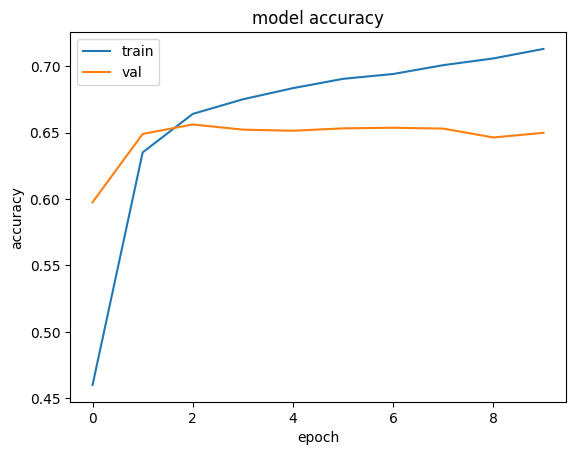

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
#retreino com novo modelo e todos os dados por apenas 4 epocas

model = Criar_Modelo()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X1 = tokenizer.texts_to_sequences(reviews)
X1 = pad_sequences(X1, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X2 = recomends

y = np.array(label_tokenizer.texts_to_sequences(ratings))

final_history = model.fit((X1,X2), y, epochs=4, verbose=1, batch_size=1000)

Epoch 1/4
78/78 [==============================] - 273s 3s/step - loss: 1.2338 - accuracy: 0.4946
Epoch 2/4
78/78 [==============================] - 281s 4s/step - loss: 0.8102 - accuracy: 0.6440
Epoch 3/4
78/78 [==============================] - 281s 4s/step - loss: 0.7574 - accuracy: 0.6674
Epoch 4/4
78/78 [==============================] - 286s 4s/step - loss: 0.7389 - accuracy: 0.6764


In [13]:
# Tratamento da base de teste

dftest = pd.read_csv('test.csv', low_memory=False, parse_dates=[1])
dftest['clean_text'] = dftest.review_title.apply(lambda x: cleantexts(x)) + ' ' + dftest.review_text.apply(lambda x: cleantexts(x))

reviews = list(dftest.clean_text.values)
X1_pred = tokenizer.texts_to_sequences(reviews)
X1_pred = pad_sequences(X1_pred, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X2_pred = dftest.recommend_to_a_friend.apply(lambda x: norm_recom(str(x))).values

#Previsão
predictions = model.predict((X1_pred, X2_pred), verbose=1, batch_size=1000)

53/53 [==============================] - 121s 2s/step


In [14]:
#Transformar previsão 'softmax' em ratings
pred=[]
for p in predictions:
    t = [[np.argmax(p)]]
    pred.append(int(label_tokenizer.sequences_to_texts(t)[0]))

#Salvar arquivoi de submissão
dftest['rating'] = pred
dftest[['ID','rating']].to_csv('submission_2.csv', index=False)